In [7]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import SGDClassifier

# download the required resource
!pip install xgboost
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

In [73]:
# Convert the bank tabular csv to a dataframe
td = pd.read_csv('./bank-data/bank-tabular.csv', 
                 delimiter='\t', 
                 index_col=None, 
                 parse_dates=['date'])
# # Convert the bank comments csv to a dataframe
# cd = pd.read_csv('./bank-data/bank-comments.csv', delimiter='\t', encoding='utf-8')

In [9]:
print(td.shape)
print(cd.shape)

(3000, 18)
(3000, 3)


In [10]:
td.dtypes

customer_id                       int64
date                     datetime64[ns]
customer_gender                  object
customer_age                    float64
customer_location                object
customer_type                    object
has_cc                             bool
has_mortgage                       bool
convenience                     float64
customer_service                float64
online_banking                  float64
interest_rates                  float64
fees_charges                    float64
community_involvement           float64
products_services               float64
privacy_security                float64
reputation                      float64
satisfied                          bool
dtype: object

From here we can see that the dataframe has columns that will need to be pre processed differently, for example the bool dtypes will not be preprocessed the same way as the float64 dtpe columns.

In [12]:
missing_valuestd = td.isnull().sum().to_frame(name='Missing Values')
print(missing_valuestd)

                       Missing Values
customer_id                         0
date                                0
customer_gender                   312
customer_age                      470
customer_location                 365
customer_type                       0
has_cc                              0
has_mortgage                        0
convenience                        64
customer_service                   29
online_banking                     30
interest_rates                    165
fees_charges                       76
community_involvement             300
products_services                 100
privacy_security                  262
reputation                        402
satisfied                           0


# Categorical Columns ( customer_gender , customer_location, customer_type)

In [14]:
# Set column as category dtype
td['customer_gender'] = td['customer_gender'] .astype('category')
td['customer_location'] = td['customer_location'] .astype('category')
td['customer_type'] = td['customer_type'] .astype('category')

In [15]:
# setting the appropriate categories:
# replace 'f' with 'Female' and 'm' with 'Male' in the 'gender' column
td['customer_gender'] = td['customer_gender'].replace({'f': 'Female', 'm': 'Male', 'Unspecified': 'Not specified'})

In [16]:
# Select only the float64 dtype columns
category_cols = td.select_dtypes(include=['category']).columns

# Impute missing values with the mode
for col in category_cols:
    mode = td[col].mode()[0]
    td[col].fillna(mode, inplace=True)

# Category columns
td[category_cols].isnull().sum()

customer_gender      0
customer_location    0
customer_type        0
dtype: int64

In [17]:
# Identify key columns
key_cols = ['date', 'customer_id', 'customer_gender', 'customer_age', 'customer_location', 'customer_type']

# Check for duplicates
duplicates = td.duplicated(subset=key_cols)

# Print out duplicate rows
if duplicates.any():
    duplicate_rows = df[duplicates].sort_values(by=key_cols)
    print("Duplicate rows:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")
    
# Count number of duplicates
num_duplicates = duplicates.sum()
print(f"Number of duplicates: {num_duplicates}")

# # Drop duplicates if necessary
# df.drop_duplicates(subset=key_cols, inplace=True)

No duplicate rows found.
Number of duplicates: 0


In [18]:
# convert the 'date' column to datetime datatype
td['date'] = pd.to_datetime(td['date'])
cd['date'] = pd.to_datetime(cd['date'])

# set the 'date_col' column as the index
td = td.set_index('date')
cd = cd.set_index('date')

Missing values: 0
Female           52.333333
Male             39.166667
Not specified     8.500000
Name: customer_gender, dtype: float64


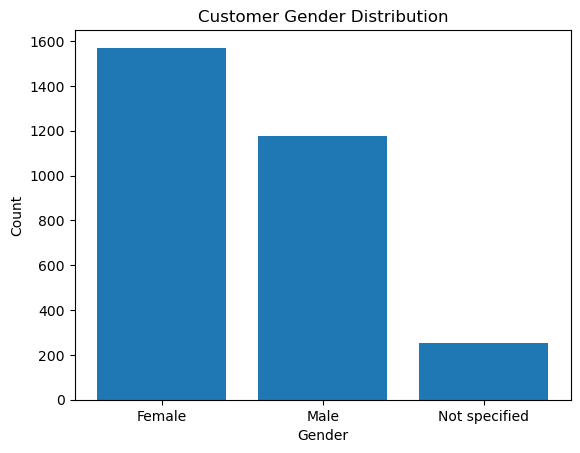

In [19]:
missing_values = td['customer_gender'].isnull().sum()
print("Missing values:", missing_values)

# Frequency table for customer gender
gender_counts = td['customer_gender'].value_counts()
gender_dist = (gender_counts / (gender_counts.sum()))*100
print(gender_dist)

# Bar chart for customer gender
plt.bar(gender_counts.index, gender_counts.values)
plt.title('Customer Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [20]:
# Perform one-hot encoding
one_hot = pd.get_dummies(td['customer_gender'])

# Add the new columns to the original dataframe
td = pd.concat([td, one_hot], axis=1)

# Drop the original categorical column
td.drop('customer_gender', axis=1, inplace=True)

td = td.rename(columns={'Not specified': 'non_binary'})

# Print the resulting dataframe
td.head()

,customer_id,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied,Female,Male,non_binary
date,,,,,,,,,,,,,,,,,,,
2022-08-22,216604,50.0,Munster,Personal,True,False,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True,0,1,0
2022-11-23,259276,61.0,Leinster,Personal,True,False,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True,1,0,0
2022-01-21,265459,63.0,Munster,Business,True,False,2.0,2.0,5.0,5.0,2.0,NaN,4.0,4.0,NaN,True,1,0,0
2022-03-13,58770,NaN,Leinster,Business,True,False,NaN,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,True,1,0,0
2022-08-08,318031,41.0,Leinster,Personal,True,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False,1,0,0


In [21]:
_counts = td.groupby('customer_type').size()

print(_counts)

customer_type
Business         1461
Business-Plus     168
Personal         1371
dtype: int64


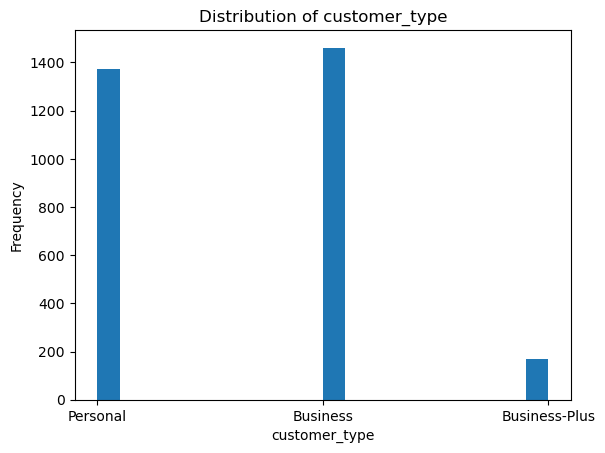

In [22]:
# Create a histogram of the customer_type column
plt.hist(td['customer_type'].dropna(), bins=20)

# Calculate and add the mean and median lines to the plot
# plt.axvline(df['customer_type'].mean(), color='red', linestyle='dashed', linewidth=2)
# plt.axvline(df['customer_type'].median(), color='green', linestyle='dashed', linewidth=2)

# Add labels and a title to the plot
plt.xlabel('customer_type')
plt.ylabel('Frequency')
plt.title('Distribution of customer_type')

# Show the plot
plt.show()

In [23]:
# # Define the label encoder object
# le = LabelEncoder()

# # Define the mapping of categories to integer values
# cat_mapping = {'Business-Plus': 0, 'Business': 1, 'Personal': 2}

# # Create a new column with the encoded values
# td['customer_type_encoded'] = td['customer_type'].map(cat_mapping)

# use get_dummies to one hot encode the customer_type column
one_hot_encoded = pd.get_dummies(td['customer_type'])

# add the one-hot encoded columns back to the original dataframe
td = pd.concat([td, one_hot_encoded], axis=1)

# Use the LabelEncoder object to fit and transform the categorical column
# td['customer_type_encoded'] = le.fit_transform(td['customer_type'])

# Print the first 5 rows of the new column
# print(td['customer_type_encoded'].head())

In [24]:
td.head()

,customer_id,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,...,products_services,privacy_security,reputation,satisfied,Female,Male,non_binary,Business,Business-Plus,Personal
date,,,,,,,,,,,,,,,,,,,,,
2022-08-22,216604,50.0,Munster,Personal,True,False,4.0,5.0,4.0,4.0,...,5.0,2.0,4.0,True,0,1,0,0,0,1
2022-11-23,259276,61.0,Leinster,Personal,True,False,5.0,5.0,5.0,3.0,...,4.0,5.0,5.0,True,1,0,0,0,0,1
2022-01-21,265459,63.0,Munster,Business,True,False,2.0,2.0,5.0,5.0,...,4.0,4.0,NaN,True,1,0,0,1,0,0
2022-03-13,58770,NaN,Leinster,Business,True,False,NaN,4.0,5.0,1.0,...,5.0,5.0,5.0,True,1,0,0,1,0,0
2022-08-08,318031,41.0,Leinster,Personal,True,True,1.0,1.0,1.0,1.0,...,4.0,5.0,2.0,False,1,0,0,0,0,1


In the above steps we have employed one hot encoding to ensure we have more numerical data for the later on tasks for classification.

#### Dealing with customer_age column with the use of Bins

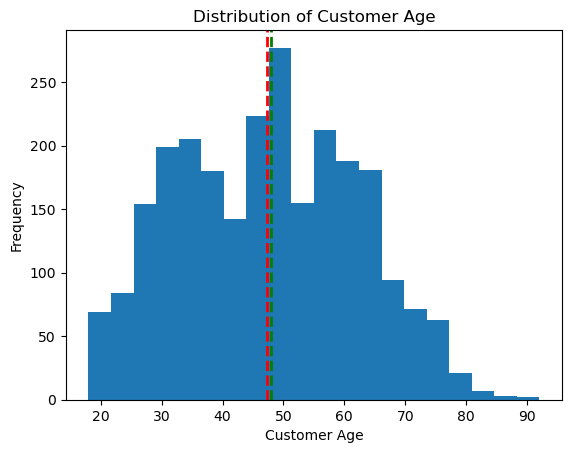

In [220]:
# Create a histogram of the customer age column
plt.hist(td['customer_age'].dropna(), bins=20)

# Calculate and add the mean and median lines to the plot
plt.axvline(td['customer_age'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(td['customer_age'].median(), color='green', linestyle='dashed', linewidth=2)

# Add labels and a title to the plot
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.title('Distribution of Customer Age')

# Show the plot
plt.show()

In [221]:
print(td.customer_age.min())
print(td.customer_age.max())
# Customer_age ranges from 18 as the min and 92 as the max

td.customer_age.describe()

18.0
92.0


count    2530.000000
mean       47.281818
std        14.655691
min        18.000000
25%        35.000000
50%        48.000000
75%        58.000000
max        92.000000
Name: customer_age, dtype: float64

In [222]:
# Define bin edges
bin_edges = [0, 25, 35, 45, 55, 65, 75, 100]

# Create labels for the bins
bin_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']

# Use pandas cut function to create age groups
td['customer_age'] = pd.cut(td['customer_age'], bins=bin_edges, labels=bin_labels, include_lowest=True)

In [28]:
print(td.customer_age.min())
print(td.customer_age.max())
# Customer_age ranges from 18 as the min and 92 as the max

td.customer_age.describe()

18-24
75+


count      2530
unique        7
top       45-54
freq        608
Name: customer_age, dtype: object

In [29]:
td.head()

,customer_id,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,...,products_services,privacy_security,reputation,satisfied,Female,Male,non_binary,Business,Business-Plus,Personal
date,,,,,,,,,,,,,,,,,,,,,
2022-08-22,216604,45-54,Munster,Personal,True,False,4.0,5.0,4.0,4.0,...,5.0,2.0,4.0,True,0,1,0,0,0,1
2022-11-23,259276,55-64,Leinster,Personal,True,False,5.0,5.0,5.0,3.0,...,4.0,5.0,5.0,True,1,0,0,0,0,1
2022-01-21,265459,55-64,Munster,Business,True,False,2.0,2.0,5.0,5.0,...,4.0,4.0,NaN,True,1,0,0,1,0,0
2022-03-13,58770,NaN,Leinster,Business,True,False,NaN,4.0,5.0,1.0,...,5.0,5.0,5.0,True,1,0,0,1,0,0
2022-08-08,318031,35-44,Leinster,Personal,True,True,1.0,1.0,1.0,1.0,...,4.0,5.0,2.0,False,1,0,0,0,0,1


In [30]:
# Create a new category for missing values
td['customer_age'] = td['customer_age'].cat.add_categories('Unknown')

# Replace missing values with new category
td['customer_age'] = td['customer_age'].fillna('Unknown')

We have created a final bin to hold the unknown ages (aim is to avoid dropping rows incase they have additional data in other columns to aid in the classificiation)

In [31]:
td['customer_age'].describe()

count      3000
unique        8
top       45-54
freq        608
Name: customer_age, dtype: object

In [32]:
from sklearn.preprocessing import LabelEncoder

# Define the labels
bin_labels = ['Unknown', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the bin labels
encoded_labels = label_encoder.fit_transform(bin_labels)

# Print the encoded labels
print(encoded_labels)


[7 0 1 2 3 4 5 6]


In [33]:
# Encode the column with the encoded labels
td['customer_age_encoded'] = td['customer_age'].map(dict(zip(bin_labels, encoded_labels)))

In [34]:
td

,customer_id,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,...,privacy_security,reputation,satisfied,Female,Male,non_binary,Business,Business-Plus,Personal,customer_age_encoded
date,,,,,,,,,,,,,,,,,,,,,
2022-08-22,216604,45-54,Munster,Personal,True,False,4.0,5.0,4.0,4.0,...,2.0,4.0,True,0,1,0,0,0,1,3
2022-11-23,259276,55-64,Leinster,Personal,True,False,5.0,5.0,5.0,3.0,...,5.0,5.0,True,1,0,0,0,0,1,4
2022-01-21,265459,55-64,Munster,Business,True,False,2.0,2.0,5.0,5.0,...,4.0,NaN,True,1,0,0,1,0,0,4
2022-03-13,58770,Unknown,Leinster,Business,True,False,NaN,4.0,5.0,1.0,...,5.0,5.0,True,1,0,0,1,0,0,7
2022-08-08,318031,35-44,Leinster,Personal,True,True,1.0,1.0,1.0,1.0,...,5.0,2.0,False,1,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-23,322582,35-44,Munster,Personal,True,True,3.0,3.0,3.0,3.0,...,1.0,5.0,False,0,1,0,0,0,1,2
2021-03-07,53418,55-64,Munster,Business,False,False,3.0,2.0,5.0,1.0,...,2.0,3.0,True,1,0,0,1,0,0,4
2021-08-01,79364,Unknown,Munster,Personal,True,True,3.0,3.0,3.0,4.0,...,4.0,4.0,False,0,1,0,0,0,1,7


In [35]:
_counts = td.groupby('customer_location').size()

print(_counts)

customer_location
Connacht     379
Leinster    1613
Munster      777
Ulster       231
dtype: int64


In [36]:
# use get_dummies to one hot encode the customer_location column
one_hot_encoded = pd.get_dummies(td['customer_location'])

# add the one-hot encoded columns back to the original dataframe
td = pd.concat([td, one_hot_encoded], axis=1)

In [37]:
td.dtypes

customer_id                 int64
customer_age             category
customer_location        category
customer_type            category
has_cc                       bool
has_mortgage                 bool
convenience               float64
customer_service          float64
online_banking            float64
interest_rates            float64
fees_charges              float64
community_involvement     float64
products_services         float64
privacy_security          float64
reputation                float64
satisfied                    bool
Female                      uint8
Male                        uint8
non_binary                  uint8
Business                    uint8
Business-Plus               uint8
Personal                    uint8
customer_age_encoded     category
Connacht                    uint8
Leinster                    uint8
Munster                     uint8
Ulster                      uint8
dtype: object

In [38]:
td.isnull().sum()

customer_id                0
customer_age               0
customer_location          0
customer_type              0
has_cc                     0
has_mortgage               0
convenience               64
customer_service          29
online_banking            30
interest_rates           165
fees_charges              76
community_involvement    300
products_services        100
privacy_security         262
reputation               402
satisfied                  0
Female                     0
Male                       0
non_binary                 0
Business                   0
Business-Plus              0
Personal                   0
customer_age_encoded       0
Connacht                   0
Leinster                   0
Munster                    0
Ulster                     0
dtype: int64

# Focus on Numerical ( rating columns )

In [39]:
# Replace missing values with mean value for the column
td.convenience.fillna(td.convenience .mean(), inplace=True)
td.customer_service.fillna(td.customer_service.mean(), inplace=True)
td.online_banking.fillna(td.online_banking.mean(), inplace=True)
td.interest_rates.fillna(td.customer_service.mean(), inplace=True)
td.fees_charges.fillna(td.customer_service.mean(), inplace=True)
td.community_involvement.fillna(td.customer_service.mean(), inplace=True)
td.products_services.fillna(td.customer_service.mean(), inplace=True)
td.privacy_security.fillna(td.customer_service.mean(), inplace=True)
td.reputation .fillna(td.reputation .mean(), inplace=True)

missing_values = td.isnull().sum().to_frame(name='Missing Values')
print(missing_values)

                       Missing Values
customer_id                         0
customer_age                        0
customer_location                   0
customer_type                       0
has_cc                              0
has_mortgage                        0
convenience                         0
customer_service                    0
online_banking                      0
interest_rates                      0
fees_charges                        0
community_involvement               0
products_services                   0
privacy_security                    0
reputation                          0
satisfied                           0
Female                              0
Male                                0
non_binary                          0
Business                            0
Business-Plus                       0
Personal                            0
customer_age_encoded                0
Connacht                            0
Leinster                            0
Munster     

Missing values of the column: 0 out of 3000


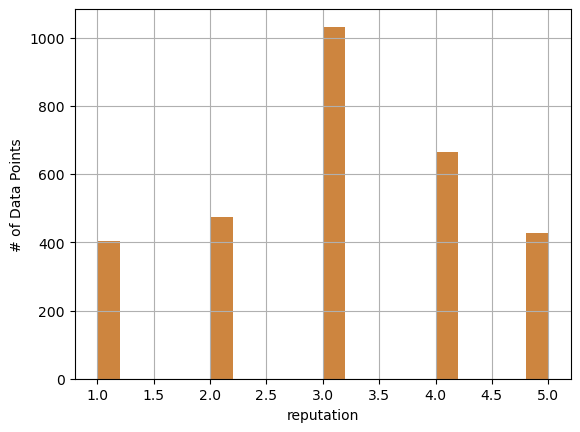

reputation
1     403
2     473
3    1032
4     665
5     427
dtype: int64


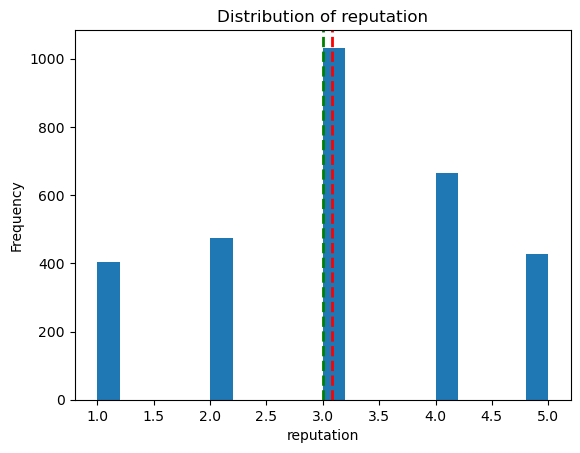

In [40]:
#Check missing values
attr = 'reputation'
td[attr] = pd.to_numeric(td[attr], errors="coerce")
td[attr] = td[attr].astype(int, errors='ignore')
missing_count = td[attr].isnull().sum()
print("Missing values of the column: %d out of %d" % (missing_count, td.shape[0]))
plt.figure()
plt.hist(td[attr], bins=20, color='peru')
plt.xlabel(attr)
plt.ylabel('# of Data Points')
plt.grid(True)
plt.show()

_counts = td.groupby('reputation').size()

print(_counts)


plt.hist(td['reputation'].dropna(), bins=20)

# Calculate and add the mean and median lines to the plot
plt.axvline(td['reputation'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(td['reputation'].median(), color='green', linestyle='dashed', linewidth=2)

# Add labels and a title to the plot
plt.xlabel('reputation')
plt.ylabel('Frequency')
plt.title('Distribution of reputation')

# Show the plot
plt.show()

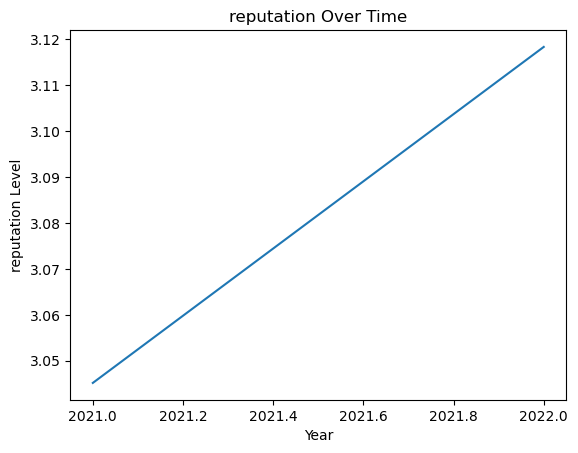

In [41]:
# Group by year and calculate average reputation level
td['year'] = pd.DatetimeIndex(td.index).year
reputation_by_year = td.groupby('year')['reputation'].mean()

# Line chart for satisfaction level over time
import matplotlib.pyplot as plt
plt.plot(reputation_by_year.index, reputation_by_year.values)
plt.title('reputation Over Time')
plt.xlabel('Year')
plt.ylabel('reputation Level')
plt.show()

Missing values of the column: 0 out of 3000


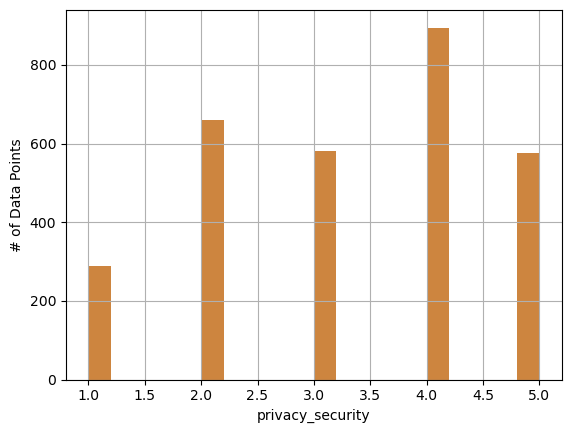

privacy_security
1    288
2    660
3    581
4    895
5    576
dtype: int64


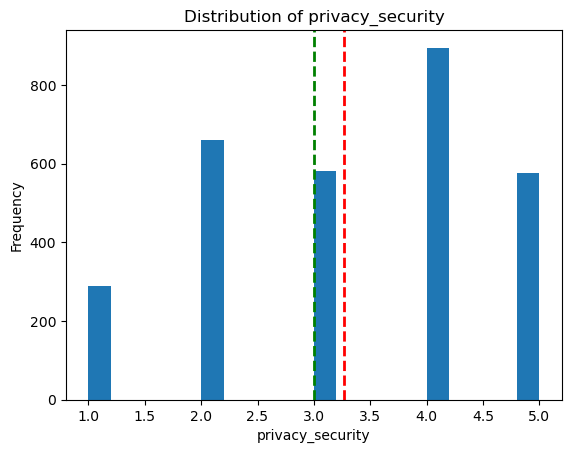

In [42]:
#Check missing values
attr = 'privacy_security'
td[attr] = pd.to_numeric(td[attr], errors="coerce")
td[attr] = td[attr].astype(int, errors='ignore')
missing_count = td[attr].isnull().sum()
print("Missing values of the column: %d out of %d" % (missing_count, td.shape[0]))
plt.figure()
plt.hist(td[attr], bins=20, color='peru')
plt.xlabel(attr)
plt.ylabel('# of Data Points')
plt.grid(True)
plt.show()

_counts = td.groupby('privacy_security').size()

print(_counts)


plt.hist(td['privacy_security'].dropna(), bins=20)

# Calculate and add the mean and median lines to the plot
plt.axvline(td['privacy_security'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(td['privacy_security'].median(), color='green', linestyle='dashed', linewidth=2)

# Add labels and a title to the plot
plt.xlabel('privacy_security')
plt.ylabel('Frequency')
plt.title('Distribution of privacy_security')

# Show the plot
plt.show()

Missing values of the column: 0 out of 3000


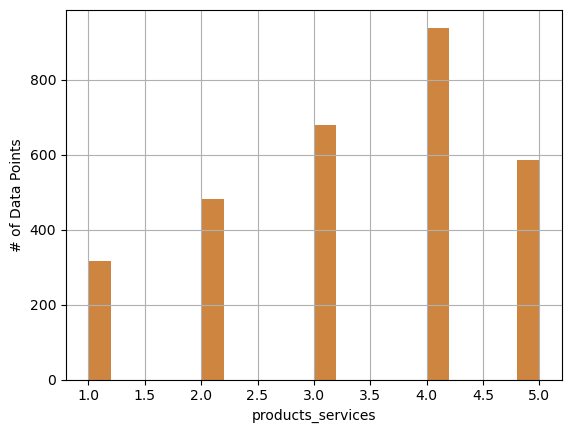

products_services
1    315
2    483
3    678
4    939
5    585
dtype: int64


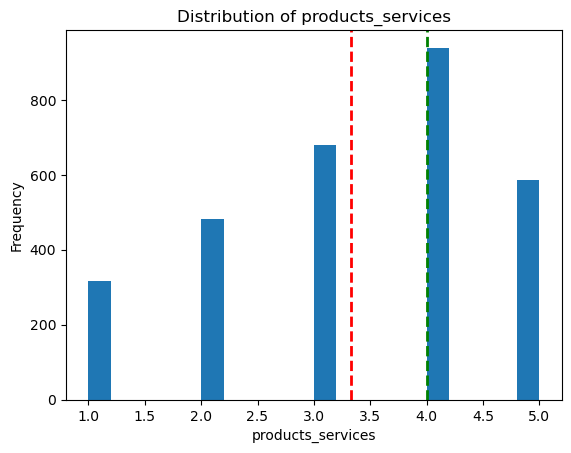

In [43]:
#Check missing values
attr = 'products_services'
td[attr] = pd.to_numeric(td[attr], errors="coerce")
td[attr] = td[attr].astype(int, errors='ignore')
missing_count = td[attr].isnull().sum()
print("Missing values of the column: %d out of %d" % (missing_count, td.shape[0]))
plt.figure()
plt.hist(td[attr], bins=20, color='peru')
plt.xlabel(attr)
plt.ylabel('# of Data Points')
plt.grid(True)
plt.show()


_counts = td.groupby('products_services').size()

print(_counts)

plt.hist(td['products_services'].dropna(), bins=20)

# Calculate and add the mean and median lines to the plot
plt.axvline(td['products_services'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(td['products_services'].median(), color='green', linestyle='dashed', linewidth=2)

# Add labels and a title to the plot
plt.xlabel('products_services')
plt.ylabel('Frequency')
plt.title('Distribution of products_services')

# Show the plot
plt.show()

Missing values of the column: 0 out of 3000


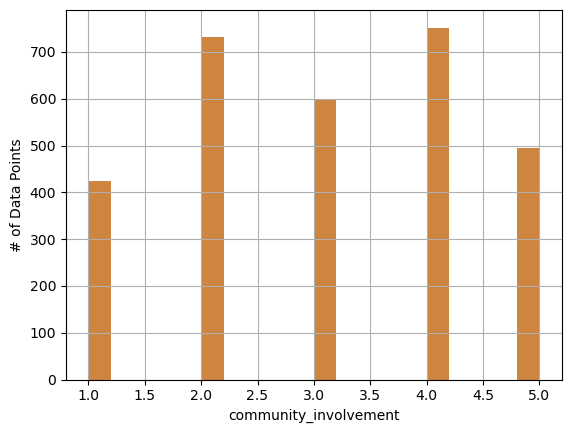

community_involvement
1    425
2    731
3    597
4    752
5    495
dtype: int64


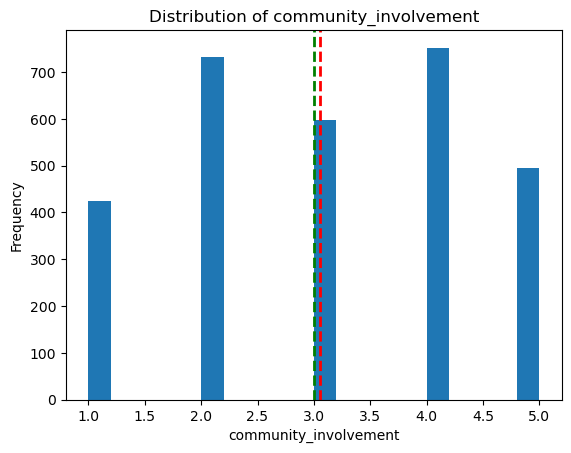

In [44]:
#Check missing values
attr = 'community_involvement'
td[attr] = pd.to_numeric(td[attr], errors="coerce")
td[attr] = td[attr].astype(int, errors='ignore')
missing_count = td[attr].isnull().sum()
print("Missing values of the column: %d out of %d" % (missing_count, td.shape[0]))
plt.figure()
plt.hist(td[attr], bins=20, color='peru')
plt.xlabel(attr)
plt.ylabel('# of Data Points')
plt.grid(True)
plt.show()

_counts = td.groupby('community_involvement').size()

print(_counts)

plt.hist(td['community_involvement'].dropna(), bins=20)

# Calculate and add the mean and median lines to the plot
plt.axvline(td['community_involvement'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(td['community_involvement'].median(), color='green', linestyle='dashed', linewidth=2)

# Add labels and a title to the plot
plt.xlabel('community_involvement')
plt.ylabel('Frequency')
plt.title('Distribution of community_involvement')

# Show the plot
plt.show()

Missing values of the column: 0 out of 3000


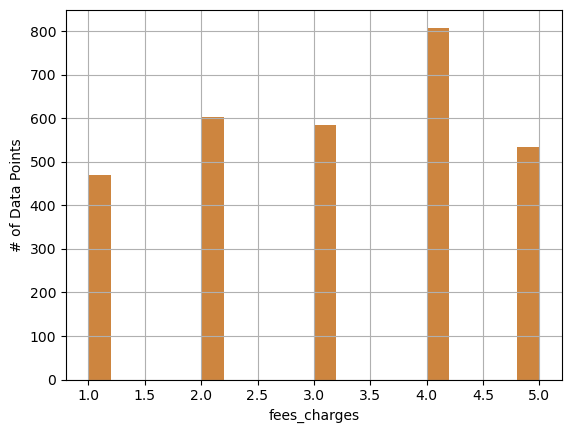

fees_charges
1    470
2    603
3    585
4    808
5    534
dtype: int64


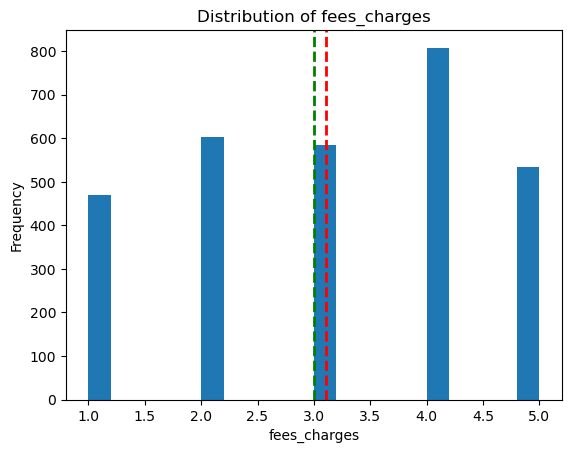

In [45]:
#Check missing values
attr = 'fees_charges'
td[attr] = pd.to_numeric(td[attr], errors="coerce")
td[attr] = td[attr].astype(int, errors='ignore')
missing_count = td[attr].isnull().sum()
print("Missing values of the column: %d out of %d" % (missing_count, td.shape[0]))
plt.figure()
plt.hist(td[attr], bins=20, color='peru')
plt.xlabel(attr)
plt.ylabel('# of Data Points')
plt.grid(True)
plt.show()

_counts = td.groupby('fees_charges').size()

print(_counts)

plt.hist(td['fees_charges'].dropna(), bins=20)

# Calculate and add the mean and median lines to the plot
plt.axvline(td['fees_charges'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(td['fees_charges'].median(), color='green', linestyle='dashed', linewidth=2)

# Add labels and a title to the plot
plt.xlabel('fees_charges')
plt.ylabel('Frequency')
plt.title('Distribution of fees_charges')

# Show the plot
plt.show()

Missing values of the column: 0 out of 3000


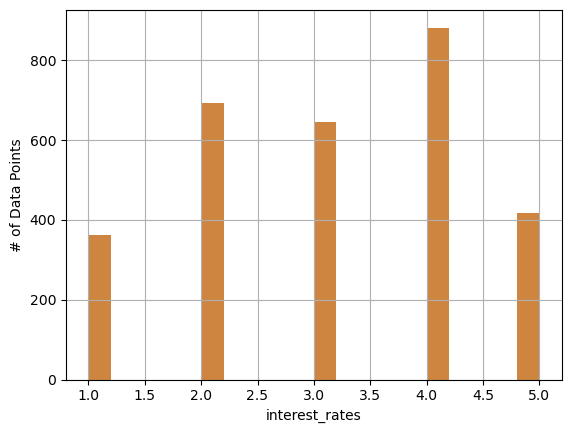

interest_rates
1    363
2    692
3    646
4    882
5    417
dtype: int64


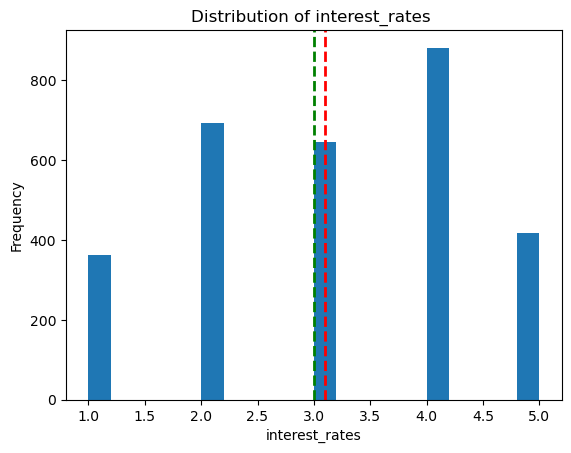

In [46]:
#Check missing values
attr = 'interest_rates'
td[attr] = pd.to_numeric(td[attr], errors="coerce")
td[attr] = td[attr].astype(int, errors='ignore')
missing_count = td[attr].isnull().sum()
print("Missing values of the column: %d out of %d" % (missing_count, td.shape[0]))
plt.figure()
plt.hist(td[attr], bins=20, color='peru')
plt.xlabel(attr)
plt.ylabel('# of Data Points')
plt.grid(True)
plt.show()

_counts = td.groupby('interest_rates').size()

print(_counts)

plt.hist(td['interest_rates'].dropna(), bins=20)

# Calculate and add the mean and median lines to the plot
plt.axvline(td['interest_rates'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(td['interest_rates'].median(), color='green', linestyle='dashed', linewidth=2)

# Add labels and a title to the plot
plt.xlabel('interest_rates')
plt.ylabel('Frequency')
plt.title('Distribution of interest_rates ')

# Show the plot
plt.show()

Missing values of the column: 0 out of 3000


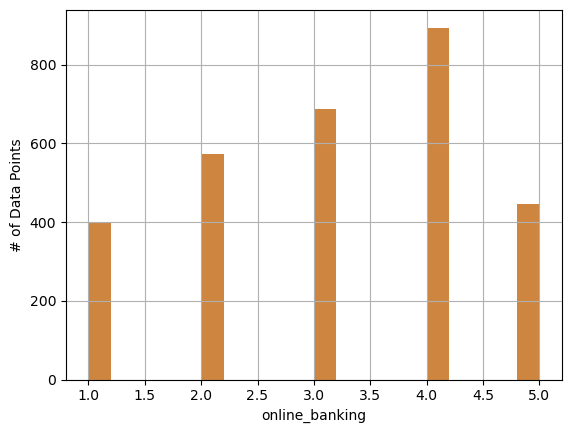

online_banking
1    399
2    574
3    687
4    894
5    446
dtype: int64


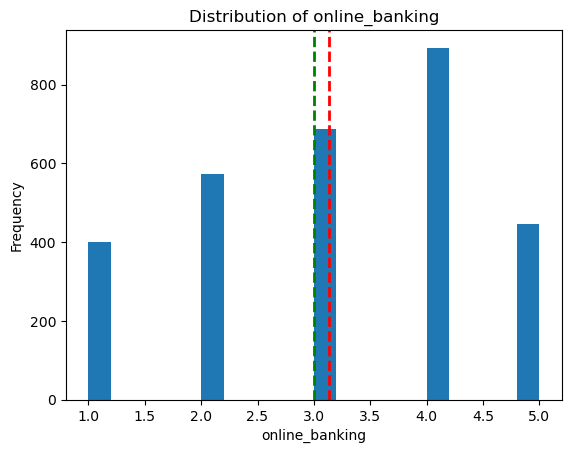

In [47]:
#Check missing values
attr = 'online_banking'
td[attr] = pd.to_numeric(td[attr], errors="coerce")
td[attr] = td[attr].astype(int, errors='ignore')
missing_count = td[attr].isnull().sum()
print("Missing values of the column: %d out of %d" % (missing_count, td.shape[0]))
plt.figure()
plt.hist(td[attr], bins=20, color='peru')
plt.xlabel(attr)
plt.ylabel('# of Data Points')
plt.grid(True)
plt.show()


_counts = td.groupby('online_banking').size()

print(_counts)

plt.hist(td['online_banking'].dropna(), bins=20)

# Calculate and add the mean and median lines to the plot
plt.axvline(td['online_banking'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(td['online_banking'].median(), color='green', linestyle='dashed', linewidth=2)

# Add labels and a title to the plot
plt.xlabel('online_banking')
plt.ylabel('Frequency')
plt.title('Distribution of online_banking')

# Show the plot
plt.show()

Missing values of the column: 0 out of 3000


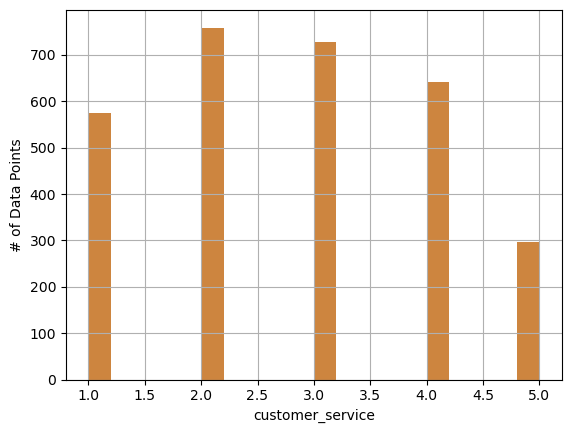

customer_service
1    575
2    759
3    728
4    642
5    296
dtype: int64


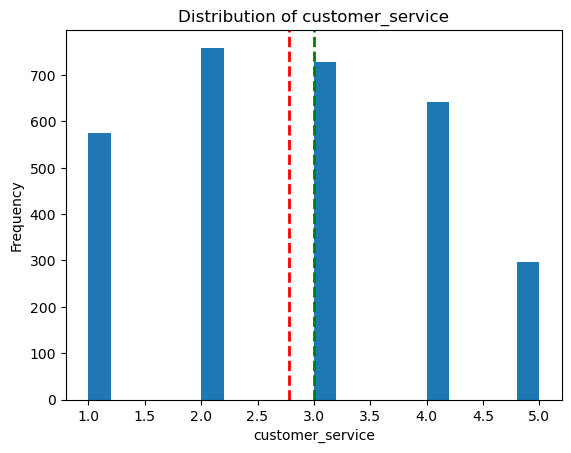

In [48]:
#Check missing values
attr = 'customer_service'
td[attr] = pd.to_numeric(td[attr], errors="coerce")
td[attr] = td[attr].astype(int, errors='ignore')
missing_count = td[attr].isnull().sum()
print("Missing values of the column: %d out of %d" % (missing_count, td.shape[0]))
plt.figure()
plt.hist(td[attr], bins=20, color='peru')
plt.xlabel(attr)
plt.ylabel('# of Data Points')
plt.grid(True)
plt.show()

_counts = td.groupby('customer_service').size()

print(_counts)

# Create a histogram of the customer_service column
plt.hist(td['customer_service'].dropna(), bins=20)

# Calculate and add the mean and median lines to the plot
plt.axvline(td['customer_service'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(td['customer_service'].median(), color='green', linestyle='dashed', linewidth=2)

# Add labels and a title to the plot
plt.xlabel('customer_service')
plt.ylabel('Frequency')
plt.title('Distribution of customer_service')

# Show the plot
plt.show()

Missing values of the column: 0 out of 3000


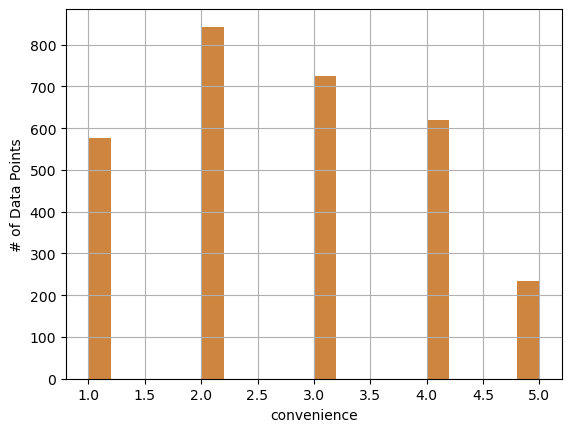

convenience
1    577
2    843
3    726
4    619
5    235
dtype: int64


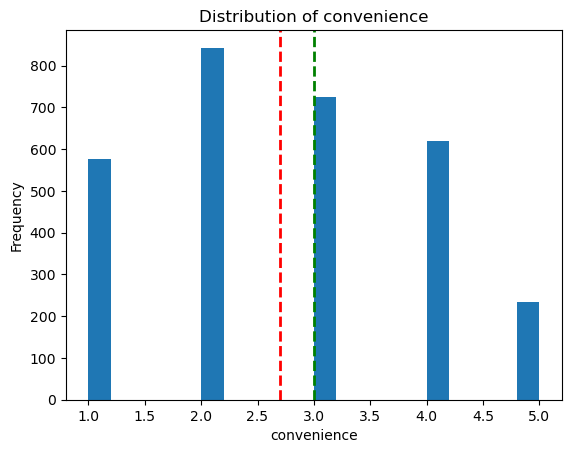

In [49]:
#Check missing values
attr = 'convenience'
td[attr] = pd.to_numeric(td[attr], errors="coerce")
td[attr] = td[attr].astype(int, errors='ignore')
missing_count = td[attr].isnull().sum()
print("Missing values of the column: %d out of %d" % (missing_count, td.shape[0]))
plt.figure()
plt.hist(td[attr], bins=20, color='peru')
plt.xlabel(attr)
plt.ylabel('# of Data Points')
plt.grid(True)
plt.show()


_counts = td.groupby('convenience').size()

print(_counts)

# Create a histogram of the convenience column
plt.hist(td['convenience'].dropna(), bins=20)

# Calculate and add the mean and median lines to the plot
plt.axvline(td['convenience'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(td['convenience'].median(), color='green', linestyle='dashed', linewidth=2)

# Add labels and a title to the plot
plt.xlabel('convenience')
plt.ylabel('Frequency')
plt.title('Distribution of convenience')

# Show the plot
plt.show()

count    3000.000000
mean        2.697333
std         1.216095
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: convenience, dtype: float64


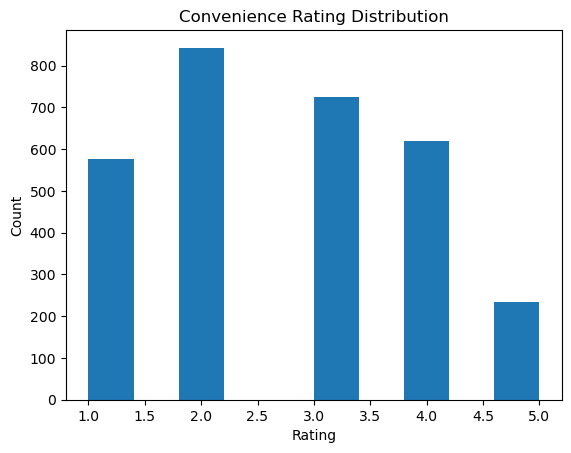

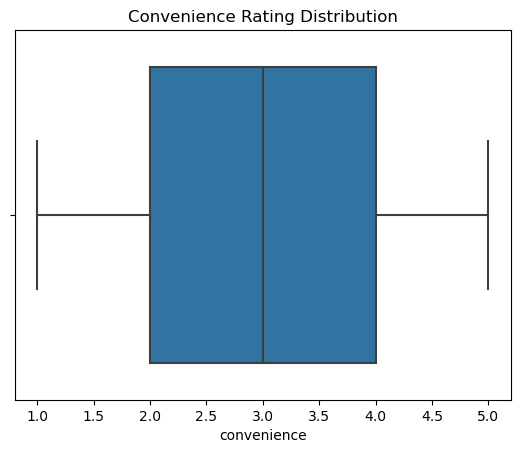

In [50]:
# Descriptive statistics for convenience rating
print(td['convenience'].describe())

# Histogram for convenience rating

plt.hist(td['convenience'], bins=10)
plt.title('Convenience Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Box plot for convenience rating
import seaborn as sns
sns.boxplot(x='convenience', data=td)
plt.title('Convenience Rating Distribution')
plt.show()

# Preprocessing for Boolean dtype columns

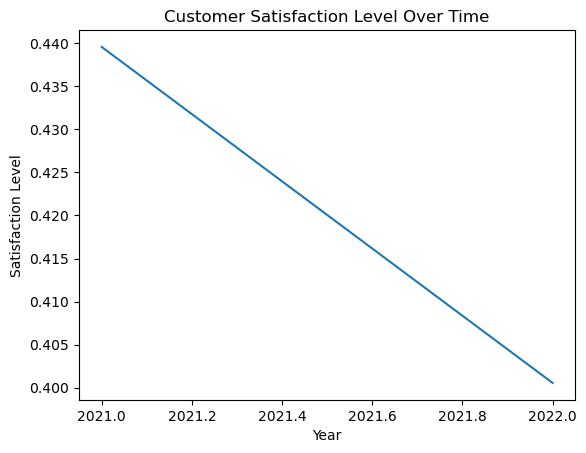

In [53]:
# Group by year and calculate average satisfaction level
# td['year'] = pd.DatetimeIndex(td.index).year
satisfaction_by_year = td.groupby(pd.DatetimeIndex(td.index).year)['satisfied'].mean()

# Line chart for satisfaction level over time
import matplotlib.pyplot as plt
plt.plot(satisfaction_by_year.index, satisfaction_by_year.values)
plt.title('Customer Satisfaction Level Over Time')
plt.xlabel('Year')
plt.ylabel('Satisfaction Level')
plt.show()

In [54]:
# Convert boolean column to integer (0 or 1)
td[['has_cc', 'has_mortgage', 'satisfied']] = td[['has_cc', 'has_mortgage', 'satisfied']].astype(int)
td = pd.get_dummies(td, columns=['has_cc', 'has_mortgage', 'satisfied'], prefix=['has_cc', 'has_mortgage', 'satisfied'])

td.dtypes

customer_id                 int64
customer_age             category
customer_location        category
customer_type            category
convenience                 int32
customer_service            int32
online_banking              int32
interest_rates              int32
fees_charges                int32
community_involvement       int32
products_services           int32
privacy_security            int32
reputation                  int32
Female                      uint8
Male                        uint8
non_binary                  uint8
Business                    uint8
Business-Plus               uint8
Personal                    uint8
customer_age_encoded     category
Connacht                    uint8
Leinster                    uint8
Munster                     uint8
Ulster                      uint8
year                        int64
has_cc_0                    uint8
has_cc_1                    uint8
has_mortgage_0              uint8
has_mortgage_1              uint8
satisfied_0   

In [55]:
td_clean = td[['customer_id', 
               'non_binary', 
               'Female',
               'Male', 
               'customer_age_encoded', 
               'Personal', 
               'Business', 
               'Business-Plus', 
               'Connacht', 
               'Leinster', 
               'Munster', 
               'Ulster', 
               'convenience', 
               'customer_service', 
               'online_banking', 
               'interest_rates',
               'fees_charges', 
               'community_involvement', 
               'products_services',
               'privacy_security', 
               'reputation', 
               'has_cc_0',
               'has_cc_1',
               'has_mortgage_0',
               'has_mortgage_1',
               'satisfied_0',
               'satisfied_1']]

In [56]:
td_clean.dtypes

customer_id                 int64
non_binary                  uint8
Female                      uint8
Male                        uint8
customer_age_encoded     category
Personal                    uint8
Business                    uint8
Business-Plus               uint8
Connacht                    uint8
Leinster                    uint8
Munster                     uint8
Ulster                      uint8
convenience                 int32
customer_service            int32
online_banking              int32
interest_rates              int32
fees_charges                int32
community_involvement       int32
products_services           int32
privacy_security            int32
reputation                  int32
has_cc_0                    uint8
has_cc_1                    uint8
has_mortgage_0              uint8
has_mortgage_1              uint8
satisfied_0                 uint8
satisfied_1                 uint8
dtype: object

In [57]:
# Select the columns to standardize
cols_to_scale = ['convenience', 'customer_service', 'online_banking', 'interest_rates',
                 'fees_charges', 'community_involvement', 'products_services',
                 'privacy_security', 'reputation']

# Create a scaler object
scaler = StandardScaler()

# Fit and transform the selected columns
td_clean[cols_to_scale] = scaler.fit_transform(td_clean[cols_to_scale])

# Preview the transformed dataframe
td.head()

C:\Users\aa_ab\AppData\Local\Temp\ipykernel_7060\3130346923.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td_clean[cols_to_scale] = scaler.fit_transform(td_clean[cols_to_scale])


,customer_id,customer_age,customer_location,customer_type,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,...,Leinster,Munster,Ulster,year,has_cc_0,has_cc_1,has_mortgage_0,has_mortgage_1,satisfied_0,satisfied_1
date,,,,,,,,,,,,,,,,,,,,,
2022-08-22,216604,45-54,Munster,Personal,4,5,4,4,4,4,...,0,1,0,2022,0,1,1,0,0,1
2022-11-23,259276,55-64,Leinster,Personal,5,5,5,3,5,4,...,1,0,0,2022,0,1,1,0,0,1
2022-01-21,265459,55-64,Munster,Business,2,2,5,5,2,2,...,0,1,0,2022,0,1,1,0,0,1
2022-03-13,58770,Unknown,Leinster,Business,2,4,5,1,5,5,...,1,0,0,2022,0,1,1,0,0,1
2022-08-08,318031,35-44,Leinster,Personal,1,1,1,1,2,2,...,1,0,0,2022,0,1,0,1,1,0


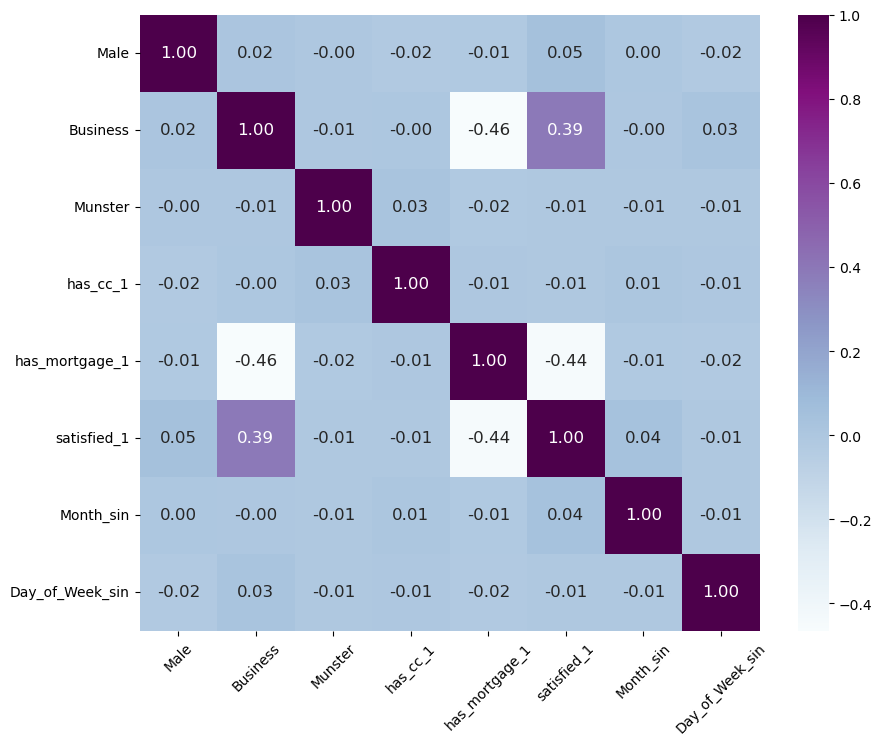

In [197]:
# Create correlation matrix
corr_matrix = td_clean.corr()

# Set threshold for strong correlation
threshold = 0.5

# Select highly correlated features
highly_correlated = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            highly_correlated.append(colname)

# Create heatmap with highly correlated features
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(td_clean[highly_correlated].corr(), annot=True, cmap='BuPu', ax=ax, xticklabels=highly_correlated, yticklabels=highly_correlated, annot_kws={"size": 12}, fmt='.2f')
plt.xticks(rotation=45)
plt.show()

Above we can see that there is a strong correlation between Business and satisified_1  as well as with has_mortgage_1 and Business

In [62]:
td= td_clean
td.dtypes

customer_id                 int64
non_binary                  uint8
Female                      uint8
Male                        uint8
customer_age_encoded     category
Personal                    uint8
Business                    uint8
Business-Plus               uint8
Connacht                    uint8
Leinster                    uint8
Munster                     uint8
Ulster                      uint8
convenience               float64
customer_service          float64
online_banking            float64
interest_rates            float64
fees_charges              float64
community_involvement     float64
products_services         float64
privacy_security          float64
reputation                float64
has_cc_0                    uint8
has_cc_1                    uint8
has_mortgage_0              uint8
has_mortgage_1              uint8
satisfied_0                 uint8
satisfied_1                 uint8
dtype: object

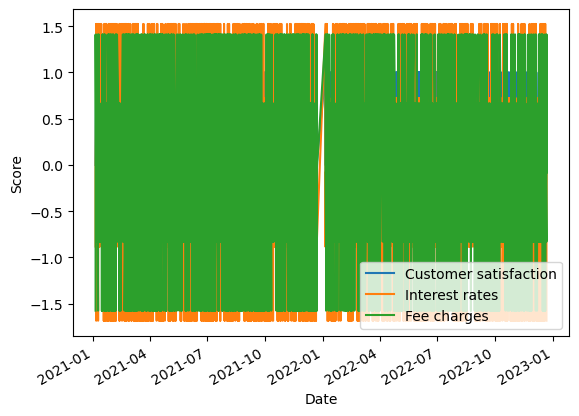

In [63]:
# plot the temporal trend of customer satisfaction with regards to interest rates and fee charges
td.plot(y=['satisfied_1', 'interest_rates', 'fees_charges'])

# add axis labels and a legend
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend(['Customer satisfaction', 'Interest rates', 'Fee charges'])

# display the plot
plt.show()

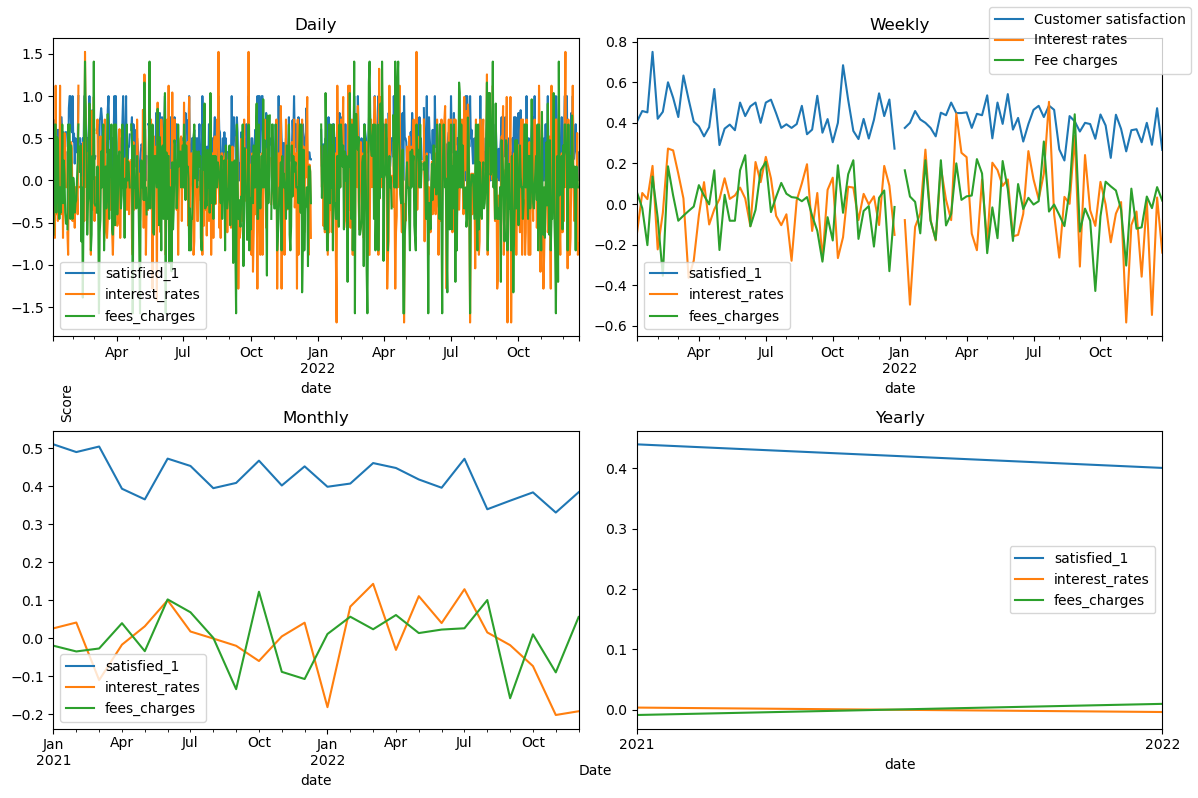

In [64]:
df = td_clean 

# resample the data to daily, weekly, monthly, and yearly frequency
df_daily = df.resample('D').mean()
df_weekly = df.resample('W').mean()
df_monthly = df.resample('M').mean()
df_yearly = df.resample('Y').mean()

# plot the temporal trend of customer satisfaction with regards to interest rates and fee charges
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

df_daily.plot(ax=ax[0, 0], y=['satisfied_1', 'interest_rates', 'fees_charges'])
ax[0, 0].set_title('Daily')

df_weekly.plot(ax=ax[0, 1], y=['satisfied_1', 'interest_rates', 'fees_charges'])
ax[0, 1].set_title('Weekly')

df_monthly.plot(ax=ax[1, 0], y=['satisfied_1', 'interest_rates', 'fees_charges'])
ax[1, 0].set_title('Monthly')

df_yearly.plot(ax=ax[1, 1], y=['satisfied_1', 'interest_rates', 'fees_charges'])
ax[1, 1].set_title('Yearly')

# add axis labels and a legend
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Score', ha='center', va='center', rotation='vertical')
fig.legend(['Customer satisfaction', 'Interest rates', 'Fee charges'], loc='upper right')

# adjust the layout and display the plot
fig.tight_layout()
plt.show()


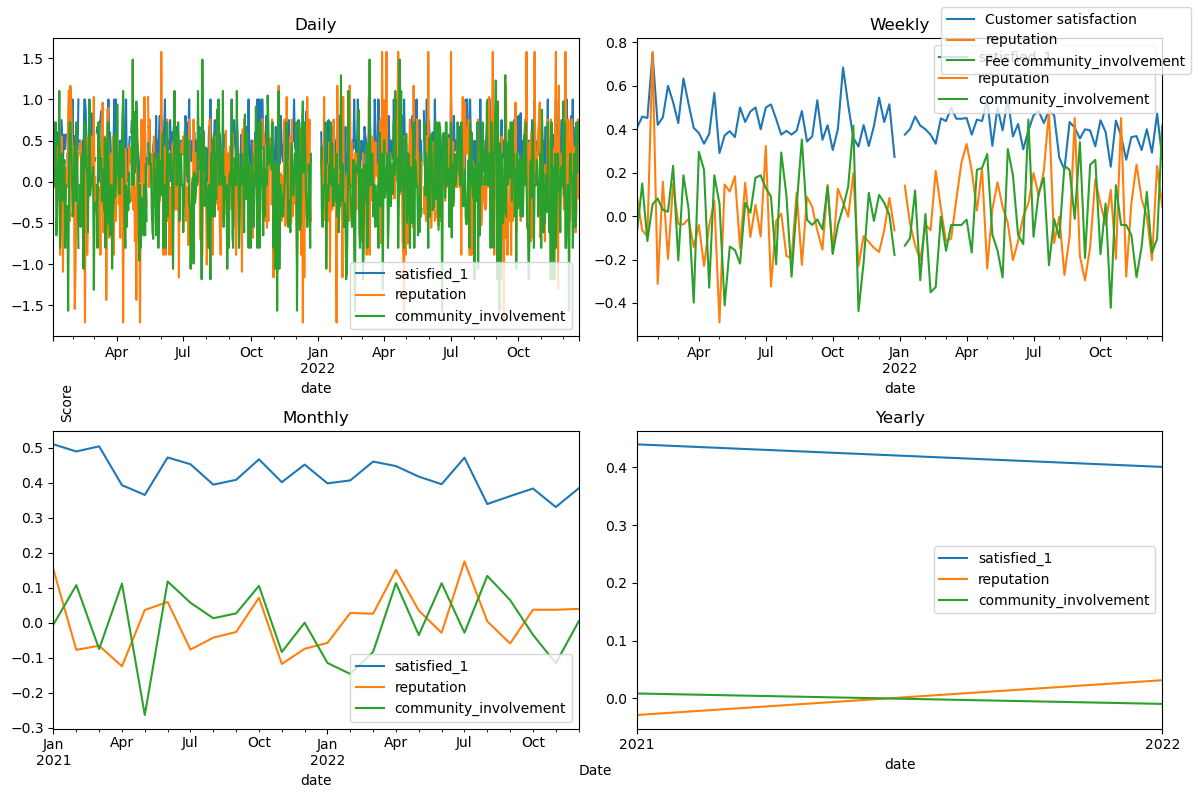

In [65]:
df = td_clean 

# resample the data to daily, weekly, monthly, and yearly frequency
df_daily = df.resample('D').mean()
df_weekly = df.resample('W').mean()
df_monthly = df.resample('M').mean()
df_yearly = df.resample('Y').mean()

# plot the temporal trend of customer satisfaction with regards to interest rates and fee charges
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

df_daily.plot(ax=ax[0, 0], y=['satisfied_1', 'reputation', 'community_involvement'])
ax[0, 0].set_title('Daily')

df_weekly.plot(ax=ax[0, 1], y=['satisfied_1', 'reputation', 'community_involvement'])
ax[0, 1].set_title('Weekly')

df_monthly.plot(ax=ax[1, 0], y=['satisfied_1', 'reputation', 'community_involvement'])
ax[1, 0].set_title('Monthly')

df_yearly.plot(ax=ax[1, 1], y=['satisfied_1', 'reputation', 'community_involvement'])
ax[1, 1].set_title('Yearly')

# add axis labels and a legend
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Score', ha='center', va='center', rotation='vertical')
fig.legend(['Customer satisfaction', 'reputation', 'Fee community_involvement'], loc='upper right')

# adjust the layout and display the plot
fig.tight_layout()
plt.show()

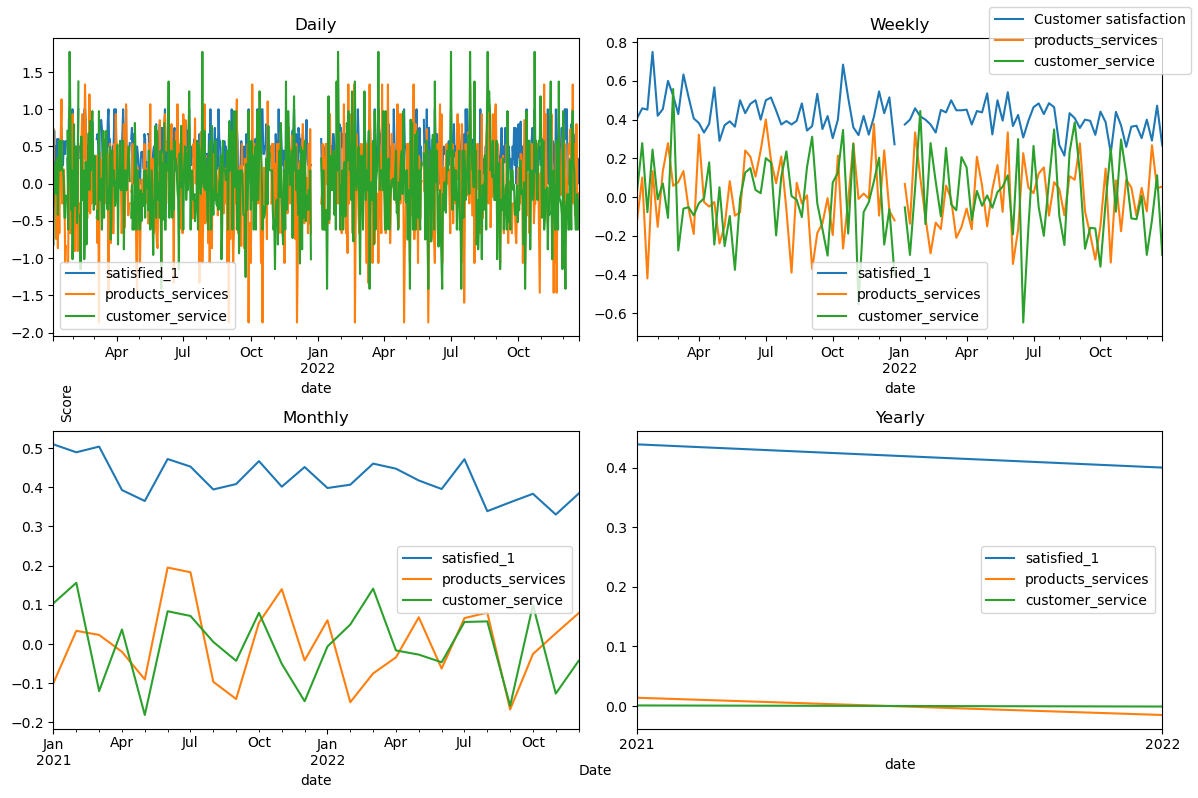

In [66]:
df = td_clean

# resample the data to daily, weekly, monthly, and yearly frequency
df_daily = df.resample('D').mean()
df_weekly = df.resample('W').mean()
df_monthly = df.resample('M').mean()
df_yearly = df.resample('Y').mean()

# plot the temporal trend of customer satisfaction with regards to interest rates and fee charges
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

df_daily.plot(ax=ax[0, 0], y=['satisfied_1', 'products_services', 'customer_service'])
ax[0, 0].set_title('Daily')

df_weekly.plot(ax=ax[0, 1], y=['satisfied_1', 'products_services', 'customer_service'])
ax[0, 1].set_title('Weekly')

df_monthly.plot(ax=ax[1, 0], y=['satisfied_1', 'products_services', 'customer_service'])
ax[1, 0].set_title('Monthly')

df_yearly.plot(ax=ax[1, 1], y=['satisfied_1', 'products_services', 'customer_service'])
ax[1, 1].set_title('Yearly')

# add axis labels and a legend
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Score', ha='center', va='center', rotation='vertical')
fig.legend(['Customer satisfaction', 'products_services', 'customer_service'], loc='upper right')

# adjust the layout and display the plot
fig.tight_layout()
plt.show()

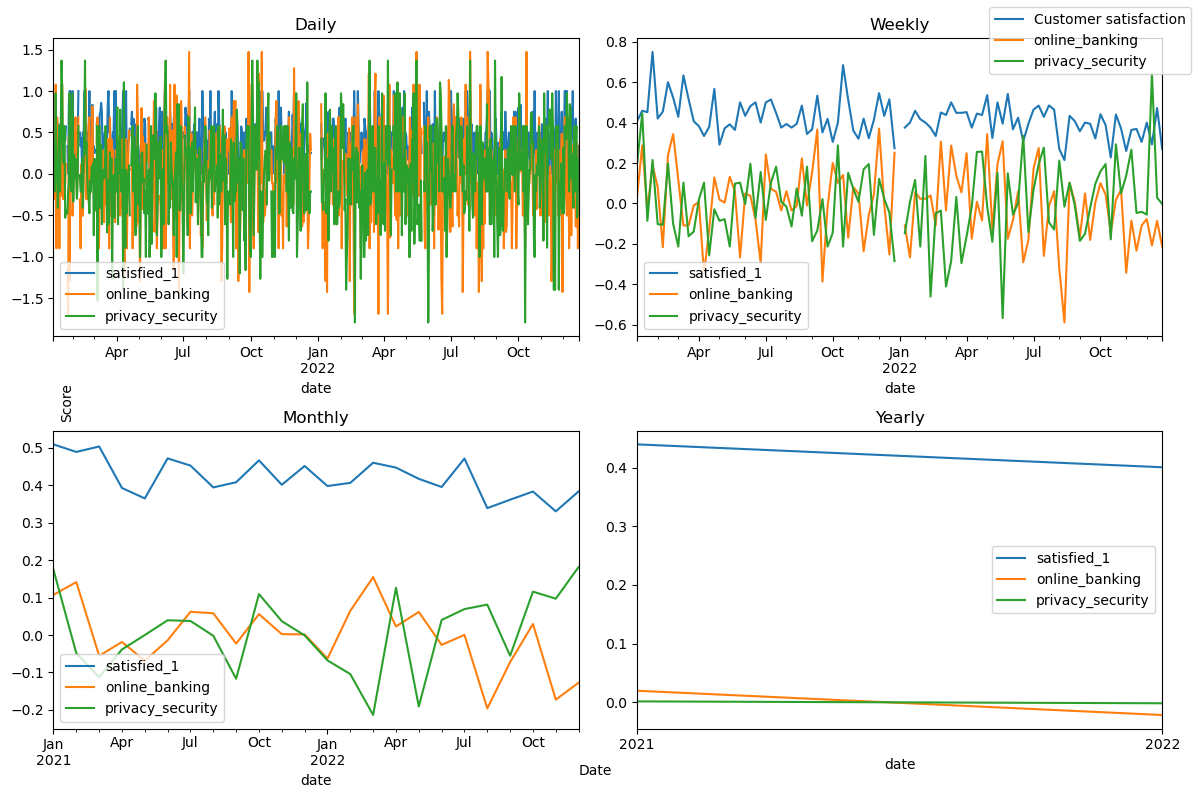

In [67]:
df = td_clean

# resample the data to daily, weekly, monthly, and yearly frequency
df_daily = df.resample('D').mean()
df_weekly = df.resample('W').mean()
df_monthly = df.resample('M').mean()
df_yearly = df.resample('Y').mean()

# plot the temporal trend of customer satisfaction with regards to interest rates and fee charges
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

df_daily.plot(ax=ax[0, 0], y=['satisfied_1', 'online_banking', 'privacy_security'])
ax[0, 0].set_title('Daily')

df_weekly.plot(ax=ax[0, 1], y=['satisfied_1', 'online_banking', 'privacy_security'])
ax[0, 1].set_title('Weekly')

df_monthly.plot(ax=ax[1, 0], y=['satisfied_1', 'online_banking', 'privacy_security'])
ax[1, 0].set_title('Monthly')

df_yearly.plot(ax=ax[1, 1], y=['satisfied_1', 'online_banking', 'privacy_security'])
ax[1, 1].set_title('Yearly')

# add axis labels and a legend
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Score', ha='center', va='center', rotation='vertical')
fig.legend(['Customer satisfaction', 'online_banking', 'privacy_security'], loc='upper right')

# adjust the layout and display the plot
fig.tight_layout()
plt.show()

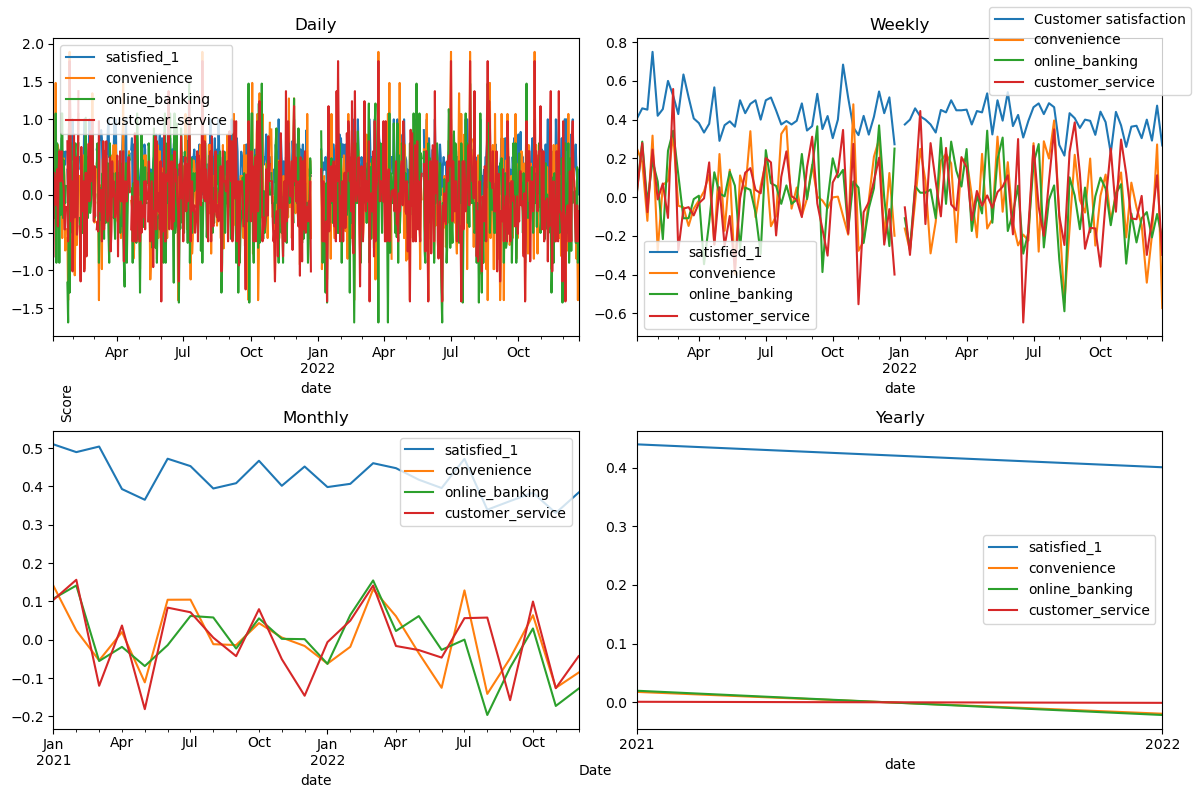

In [68]:
df = td_clean 

# resample the data to daily, weekly, monthly, and yearly frequency
df_daily = df.resample('D').mean()
df_weekly = df.resample('W').mean()
df_monthly = df.resample('M').mean()
df_yearly = df.resample('Y').mean()

# plot the temporal trend of customer satisfaction with regards to interest rates and fee charges
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

df_daily.plot(ax=ax[0, 0], y=['satisfied_1', 'convenience', 'online_banking', 'customer_service'])
ax[0, 0].set_title('Daily')

df_weekly.plot(ax=ax[0, 1], y=['satisfied_1', 'convenience', 'online_banking', 'customer_service'])
ax[0, 1].set_title('Weekly')

df_monthly.plot(ax=ax[1, 0], y=['satisfied_1', 'convenience', 'online_banking','customer_service' ])
ax[1, 0].set_title('Monthly')

df_yearly.plot(ax=ax[1, 1], y=['satisfied_1', 'convenience', 'online_banking', 'customer_service'])
ax[1, 1].set_title('Yearly')

# add axis labels and a legend
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Score', ha='center', va='center', rotation='vertical')
fig.legend(['Customer satisfaction', 'convenience', 'online_banking', 'customer_service'], loc='upper right')

# adjust the layout and display the plot
fig.tight_layout()
plt.show()

In [180]:
# Convert index to datetime column
td_clean.index = pd.to_datetime(td_clean.index)

# Reset index to integer index
td_clean = td_clean.reset_index()

In [185]:
td_clean['Month'] = td_clean.date.dt.month
td_clean['Day_of_Week'] = td_clean.date.dt.day_of_week
td_clean['Hour_of_Day'] = td_clean.date.dt.hour

#setting date as index
td_clean.set_index('date', inplace = True)
td_clean.head()

,customer_id,non_binary,Female,Male,customer_age_encoded,Personal,Business,Business-Plus,Connacht,Leinster,...,reputation,has_cc_0,has_cc_1,has_mortgage_0,has_mortgage_1,satisfied_0,satisfied_1,Month,Day_of_Week,Hour_of_Day
date,,,,,,,,,,,,,,,,,,,,,
2022-08-22,216604,0,0,1,3,1,0,0,0,0,...,0.756338,0,1,1,0,0,1,8,0,0
2022-11-23,259276,0,1,0,4,1,0,0,0,1,...,1.578444,0,1,1,0,0,1,11,2,0
2022-01-21,265459,0,1,0,4,0,1,0,0,0,...,-0.065768,0,1,1,0,0,1,1,4,0
2022-03-13,58770,0,1,0,7,0,1,0,0,1,...,1.578444,0,1,1,0,0,1,3,6,0
2022-08-08,318031,0,1,0,2,1,0,0,0,1,...,-0.887875,0,1,0,1,1,0,8,0,0


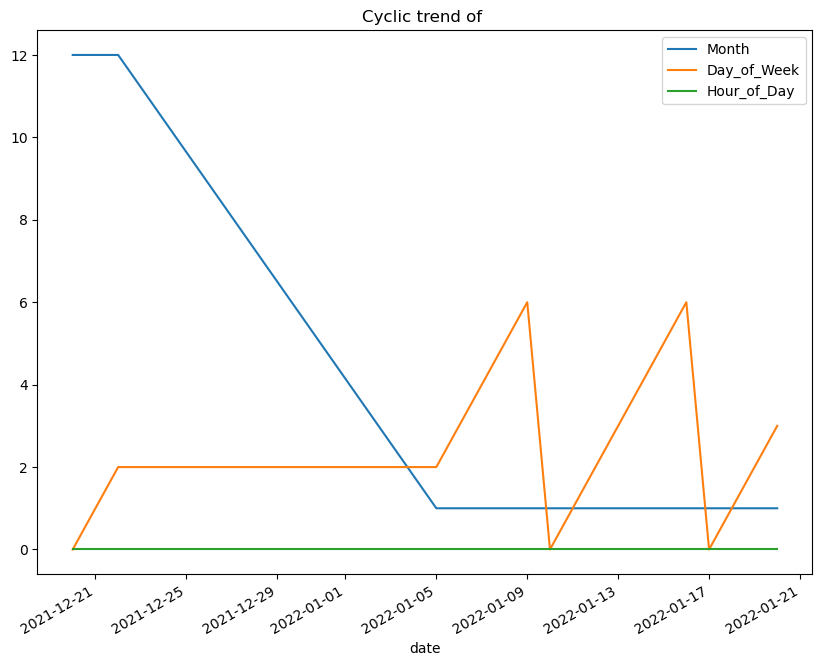

In [192]:
td_clean[['convenience', 'customer_service',
       'online_banking', 'interest_rates', 'fees_charges',
       'community_involvement', 'products_services', 'privacy_security',
       'reputation', 'satisfied_1', 'Month', 'Day_of_Week',
       'Hour_of_Day']]["2021-12-20":"2022-01-20"].plot(figsize=(10,8));
plt.title('Cyclic trend of ');

In [188]:
td_clean.columns

Index(['customer_id', 'non_binary', 'Female', 'Male', 'customer_age_encoded',
       'Personal', 'Business', 'Business-Plus', 'Connacht', 'Leinster',
       'Munster', 'Ulster', 'convenience', 'customer_service',
       'online_banking', 'interest_rates', 'fees_charges',
       'community_involvement', 'products_services', 'privacy_security',
       'reputation', 'has_cc_0', 'has_cc_1', 'has_mortgage_0',
       'has_mortgage_1', 'satisfied_0', 'satisfied_1', 'Month', 'Day_of_Week',
       'Hour_of_Day'],
      dtype='object')

C:\Users\aa_ab\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


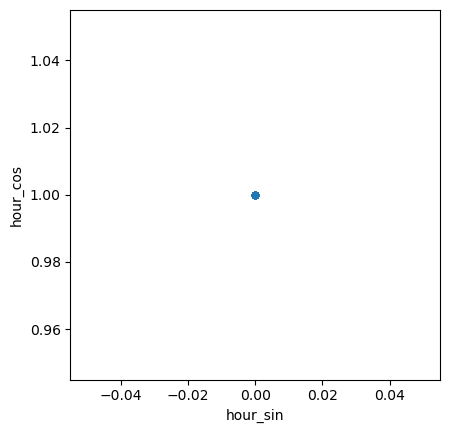

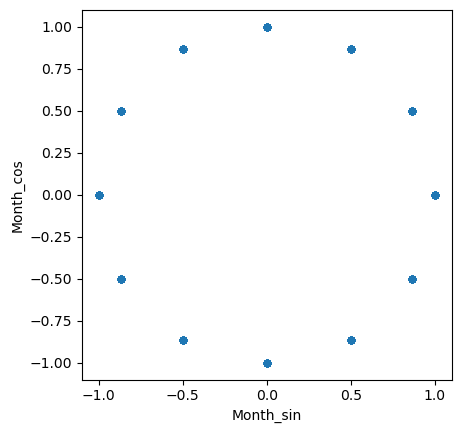

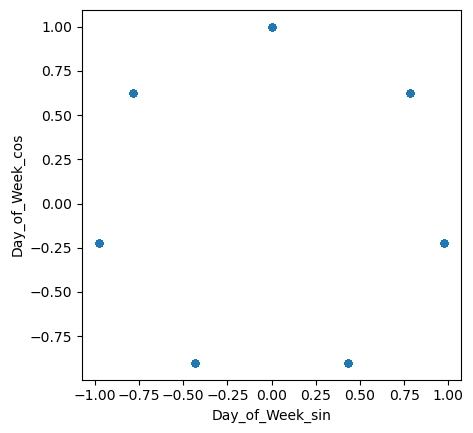

In [193]:
# Approach to deal with cyclical trends in the data


td_clean['hour_sin'] = np.sin(2 * np.pi * td_clean['Hour_of_Day']/24.0)
td_clean['hour_cos'] = np.cos(2 * np.pi * td_clean['Hour_of_Day']/24.0)

def encode(df1, col, max_val):
    td_clean[col + '_sin'] = np.sin(2 * np.pi * td_clean[col]/max_val)
    td_clean[col + '_cos'] = np.cos(2 * np.pi * td_clean[col]/max_val)
    return td_clean

td_clean= encode(td_clean, 'Month', 12)
td_clean= encode(td_clean, 'Day_of_Week', 7)

td_clean.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')
td_clean.plot.scatter('Month_sin', 'Month_cos').set_aspect('equal')
td_clean.plot.scatter('Day_of_Week_sin', 'Day_of_Week_cos').set_aspect('equal')

In [194]:
td_clean

,customer_id,non_binary,Female,Male,customer_age_encoded,Personal,Business,Business-Plus,Connacht,Leinster,...,satisfied_1,Month,Day_of_Week,Hour_of_Day,hour_sin,hour_cos,Month_sin,Month_cos,Day_of_Week_sin,Day_of_Week_cos
date,,,,,,,,,,,,,,,,,,,,,
2022-08-22,216604,0,0,1,3,1,0,0,0,0,...,1,8,0,0,0.0,1.0,-8.660254e-01,-5.000000e-01,0.000000,1.000000
2022-11-23,259276,0,1,0,4,1,0,0,0,1,...,1,11,2,0,0.0,1.0,-5.000000e-01,8.660254e-01,0.974928,-0.222521
2022-01-21,265459,0,1,0,4,0,1,0,0,0,...,1,1,4,0,0.0,1.0,5.000000e-01,8.660254e-01,-0.433884,-0.900969
2022-03-13,58770,0,1,0,7,0,1,0,0,1,...,1,3,6,0,0.0,1.0,1.000000e+00,6.123234e-17,-0.781831,0.623490
2022-08-08,318031,0,1,0,2,1,0,0,0,1,...,0,8,0,0,0.0,1.0,-8.660254e-01,-5.000000e-01,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-23,322582,0,0,1,2,1,0,0,0,0,...,0,9,3,0,0.0,1.0,-1.000000e+00,-1.836970e-16,0.433884,-0.900969
2021-03-07,53418,0,1,0,4,0,1,0,0,0,...,1,3,6,0,0.0,1.0,1.000000e+00,6.123234e-17,-0.781831,0.623490
2021-08-01,79364,0,0,1,7,1,0,0,0,0,...,0,8,6,0,0.0,1.0,-8.660254e-01,-5.000000e-01,-0.781831,0.623490


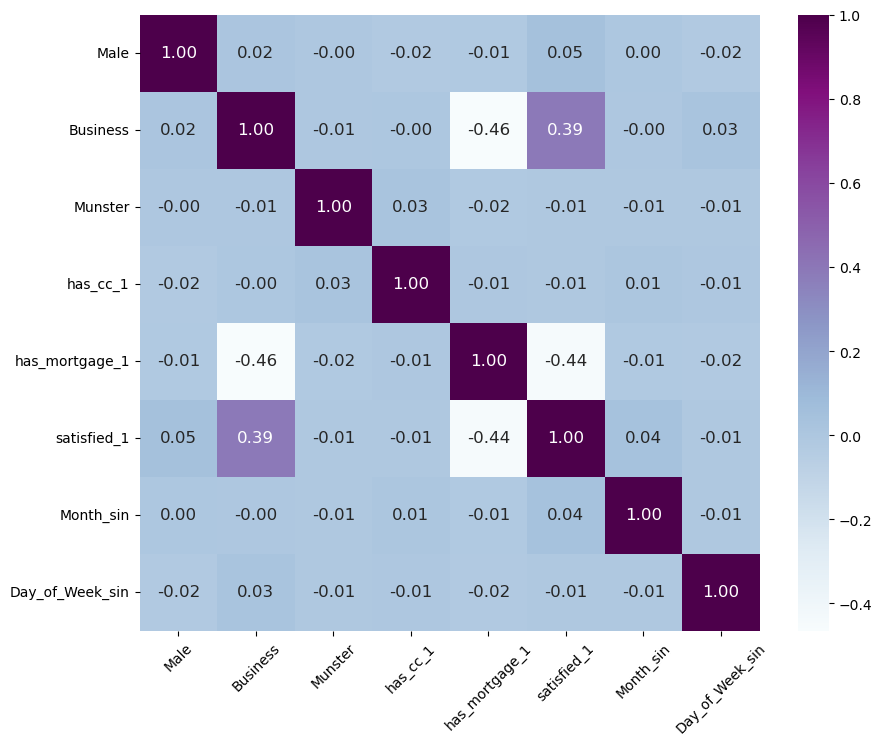

In [199]:
# Create correlation matrix
corr_matrix = td_clean.corr()

# Set threshold for strong correlation
threshold = 0.5

# Select highly correlated features
highly_correlated = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            highly_correlated.append(colname)

# Create heatmap with highly correlated features
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(td_clean[highly_correlated].corr(), annot=True, cmap='BuPu', ax=ax, xticklabels=highly_correlated, yticklabels=highly_correlated, annot_kws={"size": 12}, fmt='.2f')
plt.xticks(rotation=45)
plt.show()

In [200]:
td_clean.dtypes

customer_id                 int64
non_binary                  uint8
Female                      uint8
Male                        uint8
customer_age_encoded     category
Personal                    uint8
Business                    uint8
Business-Plus               uint8
Connacht                    uint8
Leinster                    uint8
Munster                     uint8
Ulster                      uint8
convenience               float64
customer_service          float64
online_banking            float64
interest_rates            float64
fees_charges              float64
community_involvement     float64
products_services         float64
privacy_security          float64
reputation                float64
has_cc_0                    uint8
has_cc_1                    uint8
has_mortgage_0              uint8
has_mortgage_1              uint8
satisfied_0                 uint8
satisfied_1                 uint8
Month                       int64
Day_of_Week                 int64
Hour_of_Day   

In [205]:
td_clean['customer_age_encoded'] = td_clean['customer_age_encoded'].astype(int)

In [206]:
data = td_clean
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(['satisfied_0', 'satisfied_1'], axis=1), data['satisfied_1'], test_size=0.2, random_state=42)

# Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
rfc_accuracy = accuracy_score(y_test, rfc_predictions)

# XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_predictions = xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)

# Print the accuracy of each classifier
print("Random Forest Classifier Accuracy:", rfc_accuracy)
print("XGBoost Classifier Accuracy:", xgb_accuracy)

Random Forest Classifier Accuracy: 0.87
XGBoost Classifier Accuracy: 0.8583333333333333


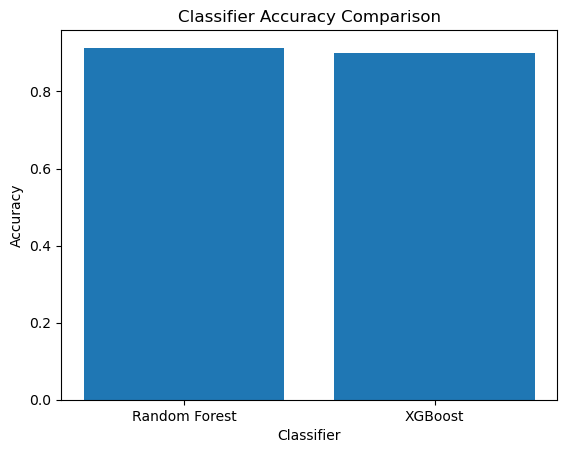

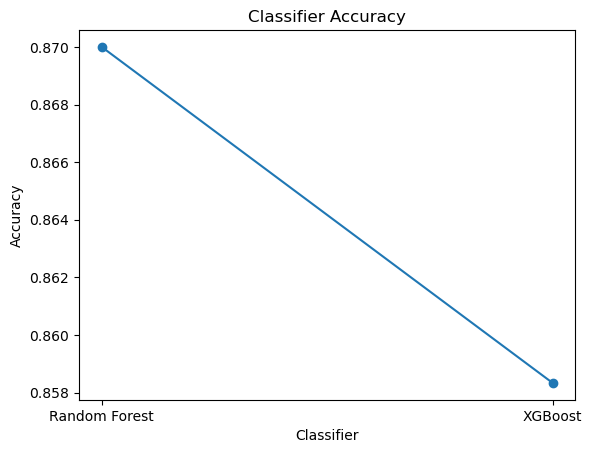

In [217]:
# Create a bar plot of classifier accuracies
classifiers = ['Random Forest', 'XGBoost']
accuracies = [rfc_accuracy, xgb_accuracy]
plt.bar(classifiers, accuracies)
plt.title('Classifier Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.show()

# define data
x = ['Random Forest', 'XGBoost']
y = [0.87, 0.8583333333333333]

# create line chart
plt.plot(x, y, marker='o')

# set chart title and labels
plt.title('Classifier Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

# display chart
plt.show()

 Random Forest Classifier has a slightly higher accuracy (0.87) than the XGBoost Classifier (0.858). However, the difference in accuracy is not significant, and other factors such as model complexity, speed, and interpretability should also be taken into account when choosing between the two models.

# Dealing with Text Data

In [158]:
# Convert the bank comments csv to a dataframe
cd = pd.read_csv('./bank-data/bank-comments.csv', delimiter='\t', encoding='utf-8')
cd.head(5)

,customer_id,date,comments
0,216604,2022-08-22,"Overal, this bank is satisfactory."
1,259276,2022-11-23,Easy to find zhe bank ' s branches and ATMs. A...
2,265459,2022-01-21,Bank's phone app is really great. In general a...
3,58770,2022-03-13,NaN
4,318031,2022-08-08,NaN


In [159]:
cd['date'] = pd.to_datetime(cd['date'])

In [160]:
cd.dropna(inplace=True)

In [161]:
cd.drop_duplicates(inplace=True)

In [162]:

stop_words = set(stopwords.words('english'))

In [163]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    """
    Map POS tag to first character used by WordNetLemmatizer
    """
    tag = tag[0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    # convert to lowercase
    text = text.lower()
    # remove numbers and special characters
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # tokenize text
    words = word_tokenize(text)
    # tag parts of speech
    tagged_words = nltk.pos_tag(words)
    # lemmatize based on POS tags
    words = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged_words if word not in stop_words]
    # join words back into a string
    text = ' '.join(words)
    return text

cd['comments'] = cd['comments'].apply(preprocess_text)


In [164]:
cd

,customer_id,date,comments
0,216604,2022-08-22,overal bank satisfactory
1,259276,2022-11-23,easy find zhe bank branch atms oll iv happy se...
2,265459,2022-01-21,bank phone app really great general good optio...
6,380865,2022-11-20,seriously considerin switch rival bank
8,219361,2021-09-25,guess bank commit sustainability reduce carbon...
...,...,...,...
2995,322582,2021-09-23,comment
2996,53418,2021-03-07,online banking really good
2997,79364,2021-08-01,customer service quality bank terrible im seri...
2998,371134,2021-06-25,great see bank support local sport team genera...


In [165]:
# Create an instance of the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to determine the sentiment score of each comment
def get_sentiment_score(comment):
    score = sia.polarity_scores(comment)
    return score['pos'] - score['neg']

# Apply the get_sentiment_score function to the comments column to get the sentiment scores for each comment
cd['sentiment_score'] = cd['comments'].apply(get_sentiment_score)

# Create a new column 'positive_comment' with values 1 if sentiment_score > 0, else 0
cd['positive_comment'] = cd['sentiment_score'].apply(lambda x: 1 if x > 0 else 0)

In [166]:
cd

,customer_id,date,comments,sentiment_score,positive_comment
0,216604,2022-08-22,overal bank satisfactory,0.556,1
1,259276,2022-11-23,easy find zhe bank branch atms oll iv happy se...,0.423,1
2,265459,2022-01-21,bank phone app really great general good optio...,0.519,1
6,380865,2022-11-20,seriously considerin switch rival bank,-0.298,0
8,219361,2021-09-25,guess bank commit sustainability reduce carbon...,0.480,1
...,...,...,...,...,...
2995,322582,2021-09-23,comment,0.000,0
2996,53418,2021-03-07,online banking really good,0.516,1
2997,79364,2021-08-01,customer service quality bank terrible im seri...,-0.348,0
2998,371134,2021-06-25,great see bank support local sport team genera...,0.637,1


In [167]:
cd.sentiment_score.describe()

count    2485.000000
mean        0.143540
std         0.347305
min        -1.000000
25%        -0.031000
50%         0.062000
75%         0.440000
max         1.000000
Name: sentiment_score, dtype: float64

The sentiment score statistics provide insights into the overall sentiment of the comments in the dataset. The mean score of 0.143540 indicates a slightly positive sentiment overall, with the majority of comments falling within the range of -0.031000 to 0.440000 (25th to 75th percentile). The standard deviation of 0.347305 indicates that there is a significant amount of variation in the sentiment scores, with some comments being highly positive (max score of 1.000000) and some being highly negative (min score of -1.000000). Therefore, it can be concluded that while the overall sentiment of the comments is slightly positive, there is a wide range of sentiment expressed in the comments.

In [171]:
# Apply different classification models to the text data to classify 'satisfied' vs 'unsatisfied' responses. Here are some popular models to consider: Naive Bayes, Logistic Regression, Random Forest, and Support Vector Machines (SVM).

# Evaluate the performance of the classifiers using metrics such as accuracy, precision, recall, and F1-score. Use techniques such as cross-validation to avoid overfitting and ensure that the models generalize well to new data.

Accuracy: 0.9537223340040242
Precision: 0.9650537634408602
Recall: 0.9728997289972899
F1-score: 0.9689608636977058
Confusion Matrix:
 [[359  10]
 [ 13 115]]


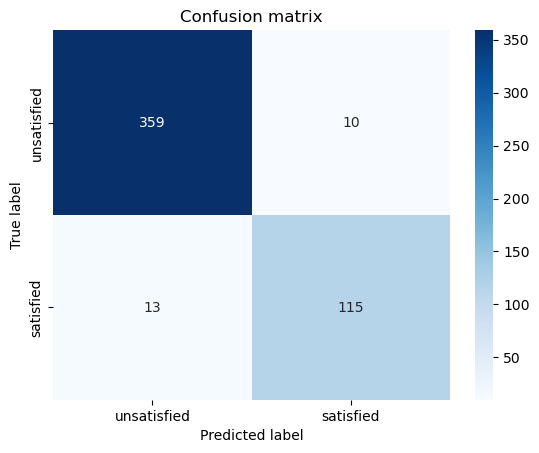

In [175]:
# Define target variable
cd['satisfaction'] = cd['sentiment_score'].apply(lambda x: 'satisfied' if x >= 0 else 'unsatisfied')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cd['comments'], cd['satisfaction'], test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Train the SVM model
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = svm.predict(X_test)

# Evaluate the performance of the classifier
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label='satisfied'))
print('Recall:', recall_score(y_test, y_pred, pos_label='satisfied'))
print('F1-score:', f1_score(y_test, y_pred, pos_label='satisfied'))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

# Visualize the confusion matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['unsatisfied', 'satisfied'], yticklabels=['unsatisfied', 'satisfied'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

First define the target variable 'satisfaction' based on the sentiment score. Then we split the data into training and testing sets, vectorize the text data using TF-IDF, and train the SVM model with a linear kernel. We then make predictions on the testing data, evaluate the performance of the classifier using various metrics, and visualize the confusion matrix using a heatmap.

Accuracy: 0.9456740442655935
Precision: 0.9672131147540983
Recall: 0.959349593495935
F1-score: 0.9632653061224489


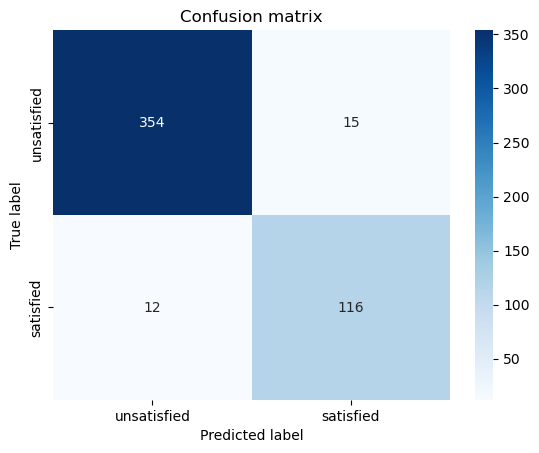

In [178]:
# Create an instance of the SGDClassifier
clf = SGDClassifier(loss='hinge', random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='satisfied')
recall = recall_score(y_test, y_pred, pos_label='satisfied')
f1 = f1_score(y_test, y_pred, pos_label='satisfied')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['unsatisfied', 'satisfied'], yticklabels=['unsatisfied', 'satisfied'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()


# Merge the clean datasets:

In [213]:
merged_df = pd.merge(cd_clean, td_clean, on='customer_id')
merged_df

,customer_id,date,sentiment_score,positive_comment,non_binary,Female,Male,customer_age_encoded,Personal,Business,...,satisfied_1,Month,Day_of_Week,Hour_of_Day,hour_sin,hour_cos,Month_sin,Month_cos,Day_of_Week_sin,Day_of_Week_cos
0,216604,2022-08-22,0.556,1,0,0,1,3,1,0,...,1,8,0,0,0.0,1.0,-8.660254e-01,-5.000000e-01,0.000000,1.000000
1,259276,2022-11-23,0.423,1,0,1,0,4,1,0,...,1,11,2,0,0.0,1.0,-5.000000e-01,8.660254e-01,0.974928,-0.222521
2,265459,2022-01-21,0.519,1,0,1,0,4,0,1,...,1,1,4,0,0.0,1.0,5.000000e-01,8.660254e-01,-0.433884,-0.900969
3,380865,2022-11-20,-0.298,0,1,0,0,2,0,1,...,0,11,6,0,0.0,1.0,-5.000000e-01,8.660254e-01,-0.781831,0.623490
4,219361,2021-09-25,0.480,1,0,0,1,4,1,0,...,1,9,5,0,0.0,1.0,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2480,322582,2021-09-23,0.000,0,0,0,1,2,1,0,...,0,9,3,0,0.0,1.0,-1.000000e+00,-1.836970e-16,0.433884,-0.900969
2481,53418,2021-03-07,0.516,1,0,1,0,4,0,1,...,1,3,6,0,0.0,1.0,1.000000e+00,6.123234e-17,-0.781831,0.623490
2482,79364,2021-08-01,-0.348,0,0,0,1,7,1,0,...,0,8,6,0,0.0,1.0,-8.660254e-01,-5.000000e-01,-0.781831,0.623490
2483,371134,2021-06-25,0.637,1,0,0,1,2,0,1,...,1,6,4,0,0.0,1.0,1.224647e-16,-1.000000e+00,-0.433884,-0.900969


In [214]:
merged_df.dtypes

customer_id                       int64
date                     datetime64[ns]
sentiment_score                 float64
positive_comment                  int64
non_binary                        uint8
Female                            uint8
Male                              uint8
customer_age_encoded              int32
Personal                          uint8
Business                          uint8
Business-Plus                     uint8
Connacht                          uint8
Leinster                          uint8
Munster                           uint8
Ulster                            uint8
convenience                     float64
customer_service                float64
online_banking                  float64
interest_rates                  float64
fees_charges                    float64
community_involvement           float64
products_services               float64
privacy_security                float64
reputation                      float64
has_cc_0                          uint8


In [216]:
data = merged_df

data['date'] = data['date'].astype(np.datetime64).astype(np.int64) // 10**9

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(['satisfied_0', 'satisfied_1'], axis=1), data['satisfied_1'], test_size=0.2, random_state=42)

# Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
rfc_accuracy = accuracy_score(y_test, rfc_predictions)

# XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_predictions = xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)

# Print the accuracy of each classifier
print("Random Forest Classifier Accuracy:", rfc_accuracy)
print("XGBoost Classifier Accuracy:", xgb_accuracy)

Random Forest Classifier Accuracy: 0.9134808853118712
XGBoost Classifier Accuracy: 0.8993963782696177


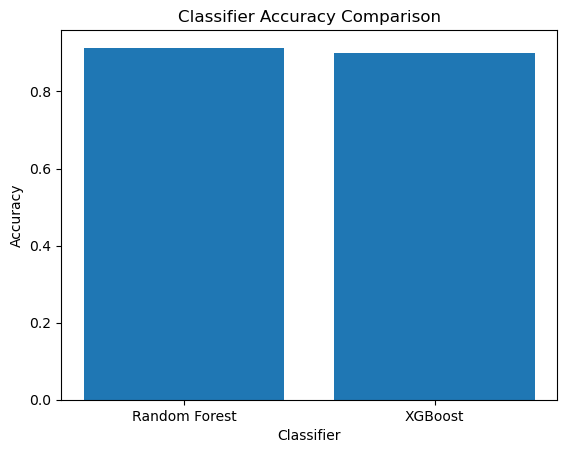

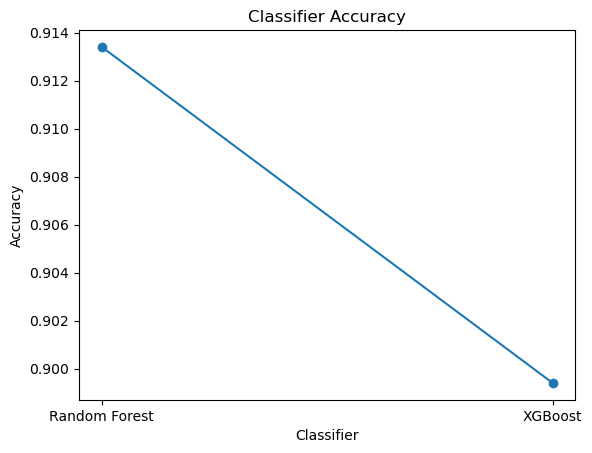

In [218]:
#  Create a bar plot of classifier accuracies
classifiers = ['Random Forest', 'XGBoost']
accuracies = [rfc_accuracy, xgb_accuracy]
plt.bar(classifiers, accuracies)
plt.title('Classifier Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.show()

# define data
x = ['Random Forest', 'XGBoost']
y = [0.9134, 0.8994]

# create line chart
plt.plot(x, y, marker='o')

# set chart title and labels
plt.title('Classifier Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

# display chart
plt.show()

# Conclusion and Discussions: 

The two datasets are significantly different with the tabular dataset offering more features which also offered up an opportunity to include all features in the models, for further analysis more insight can be looked into the cyclical features and propose a feature engineering approach to extract and focus on the features that have a high correlation and let the classifier models rely on those select features.

Looking at the text data there is heavy relience on the sentiment score and this is the determining feature for the classification and also explains why the classification models performed better using the text data in comparison to the tabular data. 

Once we have merged both clean datasets we get an improvement in the classification models with over 91% accuracy using the Random Forest classifer.


E-O-F